# Variational Gaussian Process (分類、白色化なし)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

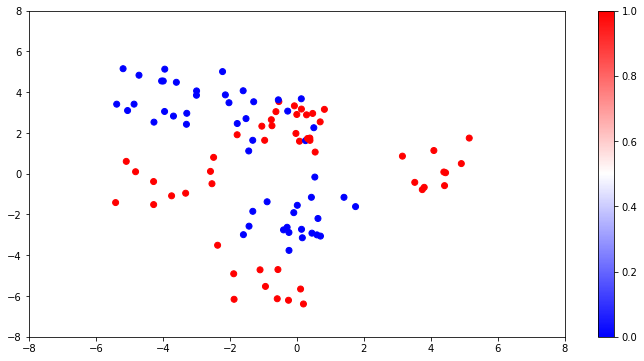

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
estimator = VGP(X, y, kernel, likelihood, whiten = False)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_steps = 10000
for step in range(n_steps):
    loss = svi.step()
    if step % (n_steps / 10) == 0:
        print(loss)

3373589.000981629
17584.36861570272
3756.56964045839
932.1255693357555
1956.8170145251795
964.4061703419387
486.13180616568945
225.99788969847134
495.08870427646485
475.7288777288136


---

## 推論結果

### 予測分布

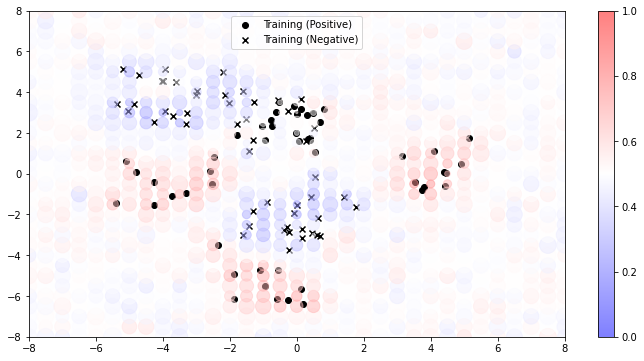

CPU times: user 701 ms, sys: 50 ms, total: 751 ms
Wall time: 587 ms


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    s = ((pnew_std - pnew_std[:, 0].min()) / pnew_std[:, 0].std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = Xnew[:, 0], y = Xnew[:, 1], c = pnew_mean[:, 0], s = s, marker = "o", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(0.4354, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.f_loc

Parameter containing:
tensor([[ 1.0095e-01, -7.8327e-01,  5.8153e-01, -4.1012e-01,  5.8139e-01,
         -6.0452e-01,  8.4660e-01, -5.2697e-01,  1.7567e-02, -6.7867e-01,
          1.5940e-01, -8.8899e-02,  8.1449e-01, -2.4541e-01,  4.6651e-01,
         -1.8825e-01,  8.3795e-01, -6.9441e-01, -3.2815e-03, -6.6149e-01,
          2.0596e-01, -5.2456e-01,  6.9128e-01, -2.7713e-03,  4.5060e-01,
         -9.8318e-01,  3.2772e-01, -3.1265e-01,  4.0053e-02, -3.2567e-01,
          1.3568e-03, -7.3264e-01,  4.7667e-01,  5.4491e-03,  4.5301e-01,
         -5.2740e-01,  8.5099e-01, -1.6313e-01, -2.1241e-04, -3.3405e-01,
          1.6225e-02, -6.8140e-01,  8.8656e-01, -1.0375e-01,  6.5705e-01,
         -3.7713e-01,  5.0684e-01, -4.5013e-01,  5.4461e-02, -3.9480e-02,
          2.8541e-02, -1.6483e-01,  9.4615e-01,  9.1720e-04,  5.2603e-01,
         -7.3050e-01,  8.0478e-01, -5.2316e-01, -1.9094e-03, -8.7605e-01,
          5.8161e-02, -8.8196e-01,  6.7896e-01, -1.5609e-02,  5.4794e-01,
         -4.3640

In [12]:
estimator.f_cov

tensor([[[ 3.9630e-01,  2.4296e-02,  1.1068e-02,  ...,  1.7147e-03,
          -9.0162e-05, -2.9134e-03],
         [ 2.4296e-02,  7.7022e-01,  4.7859e-02,  ..., -1.1316e-02,
          -2.1092e-03,  3.3724e-02],
         [ 1.1068e-02,  4.7859e-02,  8.4173e-01,  ...,  2.7421e-02,
           6.9595e-04, -2.6563e-02],
         ...,
         [ 1.7147e-03, -1.1316e-02,  2.7421e-02,  ...,  6.1396e-01,
           4.1214e-02,  2.0865e-01],
         [-9.0162e-05, -2.1092e-03,  6.9595e-04,  ...,  4.1214e-02,
           6.9813e-01, -9.8774e-02],
         [-2.9134e-03,  3.3724e-02, -2.6563e-02,  ...,  2.0865e-01,
          -9.8774e-02,  1.1554e+00]]], grad_fn=<UnsafeViewBackward>)